In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [ ]:
peek_measurement = engine.execute('SELECT * FROM Measurement LIMIT 5')
print(peek_measurement.keys())
peek_station = engine.execute('SELECT * FROM station LIMIT 5')

peek_measurement.fetchall()

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
query_latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(query_latest_date)

latest_date = dt.datetime.strptime(query_latest_date, '%Y-%m-%d')

one_year_ago = latest_date - dt.timedelta(365)
one_year_ago


2017-08-23


datetime.datetime(2016, 8, 23, 0, 0)

In [12]:
query_date_prcp = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date>=one_year_ago).all()
                                                                    

In [13]:
date_prcp_df = pd.DataFrame(query_date_prcp, columns=['date', 'precipitation']).set_index('date').sort_values(by=['date'])
date_prcp_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


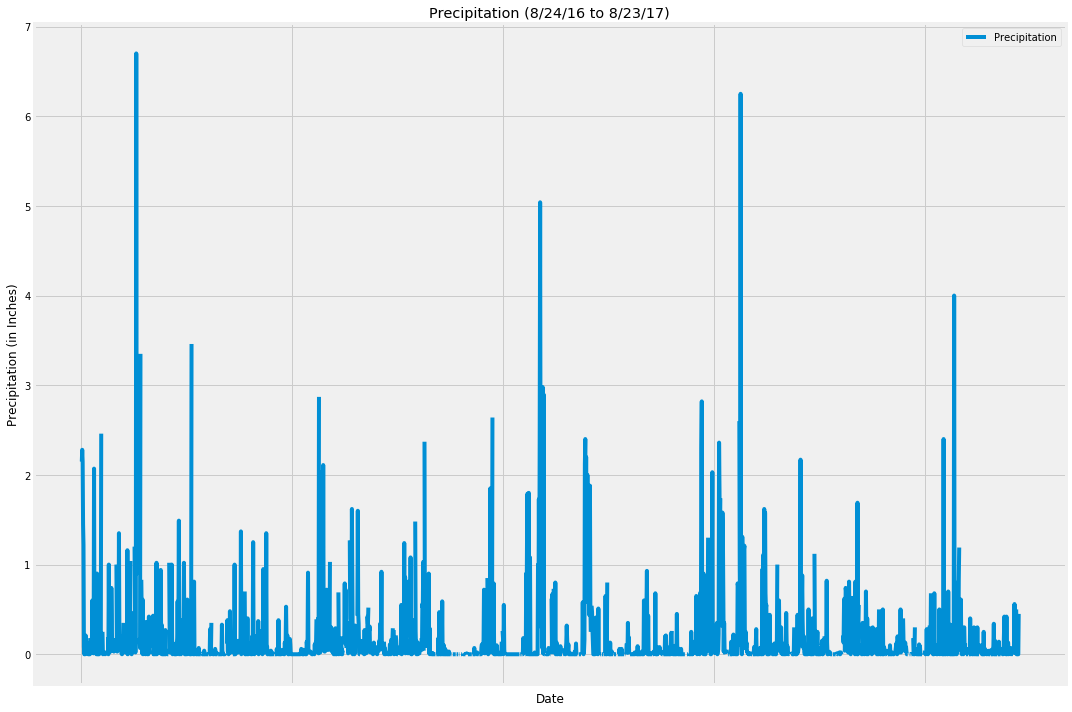

In [14]:
date_prcp_df.plot(figsize=(15,10))
plt.xlabel("Date")
plt.ylabel("Precipitation (in Inches)")
plt.title("Precipitation (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [17]:
date_prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.name)).distinct().all()

[(9)]

In [19]:
print(peek_station.keys())

peek_station.fetchall()


['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query_station_count = session.query(func.count(Measurement.station),Measurement.station).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc())

query_station_count.all()

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [21]:
most_active_station = query_station_count.limit(1)
most_active_station_id = most_active_station.all()[0][1]
print(most_active_station_id)

most_active_station_name = session.query(Station.name,Station.station).\
                        filter(Station.station == most_active_station_id).all()[0][0]

print(f'{most_active_station_name} is the most active station')

USC00519281
WAIHEE 837.5, HI US is the most active station


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_station_id).all()

[(54.0, 85.0, 71.66378066378067)]

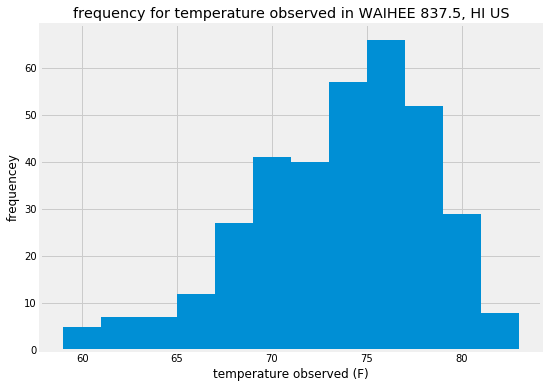

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date_temp = session.query(Measurement.tobs,Measurement.date).filter(Measurement.station==most_active_station_id).\
                filter(Measurement.date>one_year_ago).all()

date_temp_df = pd.DataFrame(date_temp,columns=['temp observed','date']).set_index('date').sort_values(by=['date'])

date_temp_df.head()

date_temp_df.hist(figsize=(8,6),bins=12)
#or plt.hist(date_temp_df['temp observed'],bins=12)
plt.xlabel('temperature observed (F)')
plt.ylabel('frequencey')
plt.title(f'frequency for temperature observed in {most_active_station_name}')
plt.show()

In [24]:
date_temp_df.head()

,temp observed
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_begin = dt.date(2018, 2, 1)
trip_end = dt.date(2018, 2, 15)
year_ago = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_begin-year_ago), (trip_end-year_ago)))
print(temp_avg_lst_year)

[(59.0, 69.72448979591837, 80.0)]


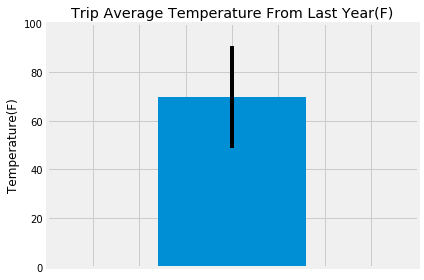

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax,tavg,tmin = temp_avg_lst_year[0]

fig, ax = plt.subplots()

ax.bar(1,tavg,yerr=tmax-tmin)
ax.set_title('Trip Average Temperature From Last Year(F)')
ax.set_ylabel("Temperature(F)")
ax.set_xticklabels([])


plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()

fig.tight_layout()
plt.show()

In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query_rainfall = session.query(func.sum(Measurement.prcp), Measurement.station ).\
                 group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).\
                 filter(Measurement.date >= trip_begin-year_ago).filter(Measurement.date <= trip_end-year_ago)

query_rainfall.all()

[(7.3100000000000005, 'USC00513117'),
 (6.91, 'USC00519523'),
 (6.2299999999999995, 'USC00519281'),
 (5.24, 'USC00514830'),
 (4.43, 'USC00516128'),
 (3.45, 'USC00519397'),
 (0.0, 'USC00517948')]

In [29]:
_, rainfall_last_yr_station_list = zip(*query_rainfall.all())
rainfall_last_yr_station_list

('USC00513117',
 'USC00519523',
 'USC00519281',
 'USC00514830',
 'USC00516128',
 'USC00519397',
 'USC00517948')

In [30]:
query_station_info_ly = session.query(Station.name, Station.latitude,Station.longitude,Station.elevation).\
                        filter(Station.station.in_(rainfall_last_yr_station_list))

query_station_info_ly.all()

[('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [31]:
list_station_info = list(zip(*query_rainfall.all()))+list(zip(*query_station_info_ly.all()))

In [32]:
list_station_info_df = pd.DataFrame(list_station_info).T

list_station_info_df.columns = ['total precipitation', 'station id','station name','latitude','longtitude','elevation']
list_station_info_df.set_index('station id', inplace=True)
list_station_info_df

,total precipitation,station name,latitude,longtitude,elevation
station id,,,,,
USC00513117,7.31,"WAIKIKI 717.2, HI US",21.2716,-157.817,3
USC00519523,6.91,"KANEOHE 838.1, HI US",21.4234,-157.802,14.6
USC00519281,6.23,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.837,7
USC00514830,5.24,"PEARL CITY, HI US",21.3934,-157.975,11.9
USC00516128,4.43,"WAIMANALO EXPERIMENTAL FARM, HI US",21.3356,-157.711,19.5
USC00519397,3.45,"WAIHEE 837.5, HI US",21.4517,-157.849,32.9
USC00517948,0,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.803,152.4


## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()[0]
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


list_of_dates = [(trip_begin+dt.timedelta(n)).strftime("%m-%d") for n in range(1+(trip_end-trip_begin).days)]
#list_of_dates

list_of_normals = [daily_normals(date) for date in list_of_dates]
list_of_normals

[(56.0, 68.14035087719299, 78.0),
 (59.0, 68.85964912280701, 77.0),
 (58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0),
 (58.0, 70.38983050847457, 77.0),
 (60.0, 69.0, 77.0),
 (56.0, 66.75438596491227, 74.0),
 (57.0, 67.58928571428571, 75.0),
 (56.0, 68.41666666666667, 76.0),
 (61.0, 69.25, 79.0),
 (60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0),
 (62.0, 70.89473684210526, 79.0),
 (56.0, 70.28813559322033, 79.0)]

In [35]:
list_of_dates

['02-01',
 '02-02',
 '02-03',
 '02-04',
 '02-05',
 '02-06',
 '02-07',
 '02-08',
 '02-09',
 '02-10',
 '02-11',
 '02-12',
 '02-13',
 '02-14',
 '02-15']

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame (list(zip(*list_of_normals))).T
normals_df['Date'] = list_of_dates
normals_df =normals_df.rename(columns = 
         {0 : 'tmin',1:'tavg',2:'tmax'})
normals_df.set_index('Date',inplace=True)
normals_df

,tmin,tavg,tmax
Date,,,
02-01,56.0,68.140351,78.0
02-02,59.0,68.859649,77.0
02-03,58.0,67.796610,77.0
02-04,61.0,68.140351,76.0
02-05,59.0,69.684211,80.0
02-06,58.0,70.389831,77.0
02-07,60.0,69.000000,77.0
02-08,56.0,66.754386,74.0
02-09,57.0,67.589286,75.0


In [37]:
# Plot the daily normals as an area plot with `stacked=False`


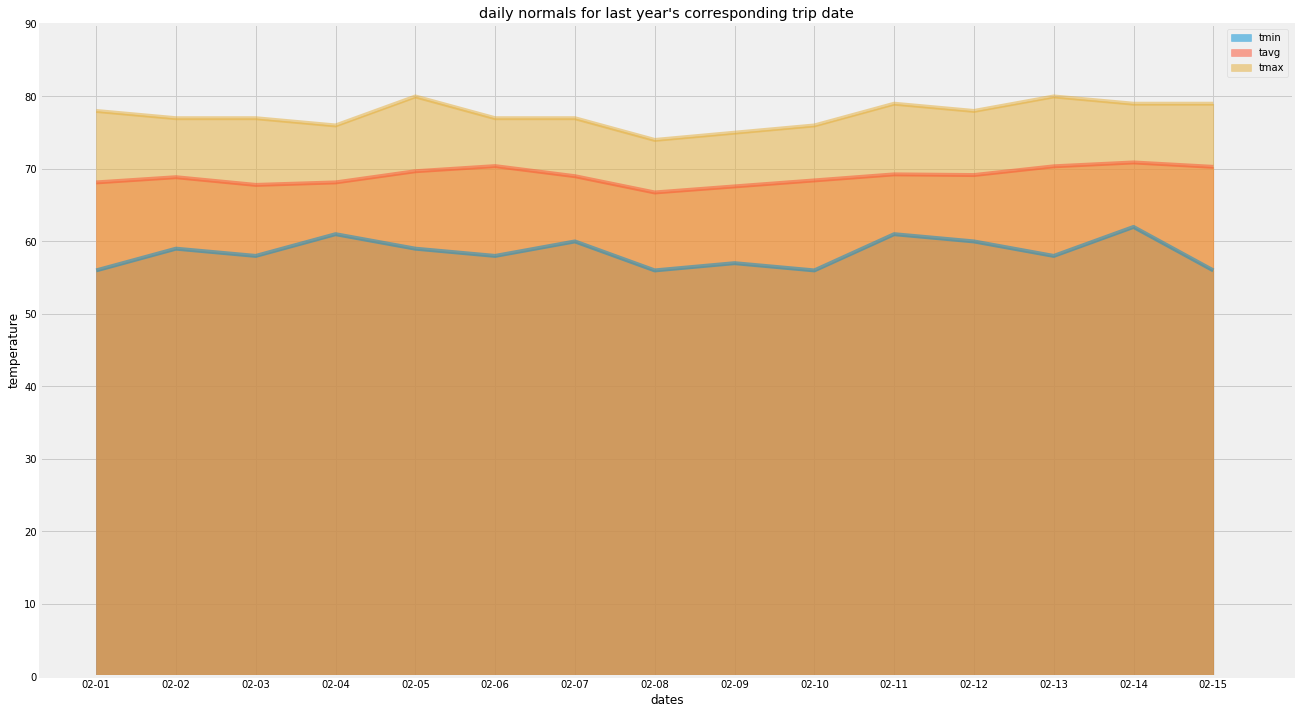

In [38]:
normals_df.plot(kind='area',stacked=False,xticks=list(range(16)),figsize=(20,12))
plt.ylim(0,90)
plt.xlabel("dates")
plt.ylabel("temperature")
plt.title("daily normals for last year's corresponding trip date")
plt.show()